In [1]:
import os
import re
from glob import glob
from importlib import reload

from collections import OrderedDict

import numpy as np

from astropy import units as u
from astropy import coordinates
from astropy.coordinates import SkyCoord, Latitude, Longitude
from astropy import table
from astropy.io import ascii
from astropy.visualization import hist as ahist
from astropy.utils import data

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [20]:
import palettable

rd, yl, bu = np.array(palettable.colorbrewer.diverging.RdYlBu_5.colors[::2])/255
yl/=1.5
rd, yl, bu

(array([ 0.84313725,  0.09803922,  0.10980392]),
 array([ 0.66666667,  0.66666667,  0.49934641]),
 array([ 0.17254902,  0.48235294,  0.71372549]))

In [4]:
# a fun trick that makes the notebook always be 95% of the browser window
from IPython.core.display import HTML
HTML("<style>.container { width:90% !important; }</style>")

# Load Relations and Data

In [5]:
import data_loaders

In [6]:
#m31 = SkyCoord.from_name('M31')
m31 = SkyCoord(10.6847083*u.deg, 41.26875*u.deg, 700*u.kpc)

In [7]:
def bradford_15_mstar_to_mgas(mstar):
    logx = np.log10(mstar/u.Msun)
    faintmsk = logx < 8.6
    mgas = np.empty_like(logx)
    mgas[faintmsk] = 1.052 *logx[faintmsk] + 0.236
    mgas[~faintmsk] = 0.461 *logx[~faintmsk] + 5.329
    return u.solMass*10**mgas

In [8]:
mcconn_tab = data_loaders.load_mccon12_table(qtable=False)
mcconn_tab.show_in_notebook(display_length=10)

idx,Name,Coords,EB-V,(m-M)o,(m-M)o+,(m-M)o-,vh(km/s),vh(km/s)+,vh(km/s)-,Vmag,Vmag+,Vmag-,PA,PA+,PA-,e=1-b/a,e=1-b/a+,e=1-b/a-,muVo,muVo+,muVo-,rh(arcmins),rh(arcmins)+,rh(arcmins)-,sigma_s(km/s),sigma_s(km/s)+,sigma_s(km/s)-,vrot_s(km/s),vrot_s(km/s)+,vrot_s(km/s)-,MHI,sigma_g(km/s),sigma_g(km/s)+,sigma_g(km/s)-,vrot_g(km/s),vrot_g(km/s)+,vrot_g(km/s)-,[Fe/H],[Fe/H]+,[Fe/H]-,F
,,"deg,deg,Mpc",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,The Galaxy,"266.4166666666667,-29.00777777777778,995405417351521.4",9.999,99.99,9.99,9.99,999.9,99.9,99.9,99.9,9.9,9.9,999.9,99.9,99.9,9.99,9.99,9.99,99.9,9.9,9.9,99.99,9.99,9.99,99.9,99.9,99.9,99.9,99.9,99.9,99.9,99.9,99.9,99.9,999.9,99.9,99.9,9.99,9.99,9.99,9.0
1,Canis Major,"108.14583333333331,-27.666666666666668,7.21107479182899",0.264,14.29,0.3,0.3,87.0,4.0,4.0,-0.1,0.8,0.8,123.0,99.9,99.9,9.99,9.99,9.99,24.0,0.6,0.6,99.99,9.99,9.99,20.0,3.0,3.0,99.9,99.9,99.9,99.9,99.9,99.9,99.9,999.9,99.9,99.9,-0.5,0.2,0.2,4.0
2,Sagittarius dSph,"283.83124999999995,-30.54527777777778,26.302679918953814",0.153,17.1,0.15,0.15,140.0,2.0,2.0,3.6,0.3,0.3,102.0,2.0,2.0,0.64,0.02,0.02,25.2,0.3,0.3,342.0,12.0,12.0,11.4,0.7,0.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.4,0.2,0.2,1.0
3,Segue (I),"151.76666666666665,16.081944444444446,22.90867652767775",0.031,16.8,0.2,0.2,208.5,0.9,0.9,15.3,0.8,0.8,85.0,8.0,8.0,0.48,0.13,0.13,27.6,1.0,1.0,4.4,1.2,0.6,3.9,0.8,0.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-2.72,0.4,0.4,2.0
4,Ursa Major II,"132.87499999999997,63.13,31.622776601683793",0.094,17.5,0.3,0.3,-116.5,1.9,1.9,13.3,0.5,0.5,98.0,4.0,4.0,0.63,0.05,0.05,27.9,0.6,0.6,16.0,1.0,1.0,6.7,1.4,1.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-2.47,0.06,0.06,2.0
5,Bootes II,"209.49999999999997,12.85,41.68693834703355",0.031,18.1,0.06,0.06,-117.0,5.2,5.2,15.4,0.9,0.9,145.0,55.0,55.0,0.21,0.21,0.21,28.1,1.6,1.6,4.2,1.4,1.4,10.5,7.4,7.4,99.9,99.9,99.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.79,0.05,0.05,3.0
6,Segue II,"34.816666666666656,20.17527777777778,34.673685045253166",0.185,17.7,0.1,0.1,-39.2,2.5,2.5,15.2,0.3,0.3,182.0,17.0,17.0,0.15,0.1,0.1,27.4,0.4,0.4,3.4,0.2,0.2,3.4,2.5,1.2,99.9,99.9,99.9,99.9,99.9,99.9,99.9,999.9,99.9,99.9,-2.22,0.13,0.13,2.0
7,Willman 1,"162.33749999999998,51.05,38.01893963205613",0.014,17.9,0.4,0.4,-12.3,2.5,2.5,15.2,0.7,0.7,77.0,5.0,5.0,0.47,0.08,0.08,26.1,0.9,0.9,2.3,0.4,0.4,4.3,2.3,1.3,99.9,99.9,99.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-2.1,9.99,9.99,2.0
8,Coma Berenices,"186.7458333333333,23.904166666666665,43.65158322401656",0.017,18.2,0.2,0.2,98.1,0.9,0.9,14.1,0.5,0.5,115.0,10.0,10.0,0.38,0.14,0.14,27.3,0.7,0.7,6.0,0.6,0.6,4.6,0.8,0.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-2.6,0.05,0.05,2.0


In [9]:
#units
# (kpc)	(km s^-1)	(L_sun)	(arcmin)	(km s^-1)	Source	(mJy beam^-1)	(M_sun)	(M_sun/L_sun)	
spekkens_tab1="""
Name	D_sun	V_LSR	L_V	r_h	epsilon	sigma_*	H I	sigma_15	MHI	MHIoL	MHIoMd	
Segue I	23	203	3.4E2	4.4	0.48	3.9	GBT	1.1	11	3.1E-2	4.1E-5	
Sagittarius dSph	26	149	2.2E7	340	0.64	11.4	BL99	23	4430	2.1E-4	2.3E-5	
Ursa Major II	32	-113	4.1E4	16	0.63	6.7	GBT	2.0	74	1.8E-3	1.9E-5	
Bootes II	42	-107	1.0E3	4.2	0.21	10.5	GBT	1.2	38	3.7E-2	1.2E-5	
Coma Berenices	44	104	3.7E3	6.0	0.38	4.6	GBT	1.8	62	1.7E-2	6.5E-5	
Bootes III	47	210	1.8E4	48^b	0.50^b	14.0	ALFALFA	2.0	1080	6.1E-2	1.5E-5	
Bootes I	66	110	2.8E4	13	0.39	2.4	GBT	1.6	252	8.9E-3	3.1E-4	
Draco	76	-274	2.8E5	10	0.31	9.1	GBT	0.75	133	4.7E-4	1.2E-5	
Ursa Minor	76	-233	2.8E5	8.2	0.56	9.5	GBT	0.61	63	2.2E-4	6.6E-6	
Sextans	86	216	4.5E5	28	0.35	7.9	GASS	29	9430	2.1E-2	3.8E-4	
Carina	105	204	3.7E5	8.2	0.33	6.6	GASS	24	4780	1.3E-2	7.6E-4	
Leo V	178	171	1.0E4	2.6	0.50	3.7	GBT	0.72	403	3.9E-2	3.7E-4	
Canes Venatici I	218	42	2.4E5	8.9	0.39	7.6	GBT	0.98	1170	4.9E-3	6.1E-5	
Leo II	233	78	7.1E5	2.6	0.13	6.6	ALFALFA	2.0	1960	2.8E-3	4.3E-4	
Leo I	254	277	5.4E6	3.4	0.21	9.2	ALFALFA	2.2	3560	6.6E-4	3.0E-4	
Cetus	755	-88	2.8E6	3.2	0.33	8.3	GASS	23	2.3E5	8.3E-2	4.4E-3	
Tucana	887	188	5.6E5	1.1	0.48	15.8	GASS	21	2.9E5	5.2E-1	3.5E-3	
Andromeda XVIII	1213	-325	5.0E5	0.92	 ... ^c	9.7	LAB	183	4.8E6	9.5E0	2.7E-1	
"""
spekkens_tab1 = ascii.read(spekkens_tab1, guess=False, delimiter='\t')
spekkens_tab1.show_in_notebook(display_length=10)

idx,Name,D_sun,V_LSR,L_V,r_h,epsilon,sigma_*,H I,sigma_15,MHI,MHIoL,MHIoMd
0,Segue I,23,203,340.0,4.4,0.48,3.9,GBT,1.1,11.0,0.031,4.1e-05
1,Sagittarius dSph,26,149,22000000.0,340,0.64,11.4,BL99,23.0,4430.0,0.00021,2.3e-05
2,Ursa Major II,32,-113,41000.0,16,0.63,6.7,GBT,2.0,74.0,0.0018,1.9e-05
3,Bootes II,42,-107,1000.0,4.2,0.21,10.5,GBT,1.2,38.0,0.037,1.2e-05
4,Coma Berenices,44,104,3700.0,6.0,0.38,4.6,GBT,1.8,62.0,0.017,6.5e-05
5,Bootes III,47,210,18000.0,48^b,0.50^b,14.0,ALFALFA,2.0,1080.0,0.061,1.5e-05
6,Bootes I,66,110,28000.0,13,0.39,2.4,GBT,1.6,252.0,0.0089,0.00031
7,Draco,76,-274,280000.0,10,0.31,9.1,GBT,0.75,133.0,0.00047,1.2e-05
8,Ursa Minor,76,-233,280000.0,8.2,0.56,9.5,GBT,0.61,63.0,0.00022,6.6e-06
9,Sextans,86,216,450000.0,28,0.35,7.9,GASS,29.0,9430.0,0.021,0.00038


# Compare LG objects to Bradford relation 

In [10]:
mtol_mccon = mtol_spekkens = 1

In [12]:
mcc_Vabs = mcconn_tab['Vmag'] + 3.1*mcconn_tab['EB-V'] - mcconn_tab['(m-M)o']
mcc_lmstar = (mcc_Vabs - 4.83)/-2.5 + np.log10(mtol_mccon)

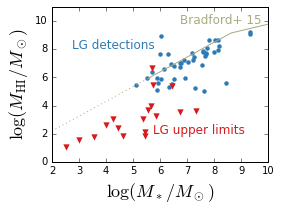

In [53]:
def make_mhi_plot(scaling=1., scaled_brad=None, legend=False, leg_alpha=1, annotation=True):
    lgmsk = (mcconn_tab['MHI']!=0)&(mcconn_tab['MHI']!=99.9) & (mcconn_tab['Vmag']!=99.9)
    plt.scatter(mcc_lmstar[lgmsk],  np.log10(mcconn_tab['MHI'][lgmsk])+6, 
                lw=0, c=bu, s=20*scaling,
                label='LG Detections (McConnachie+ 12)')

    plt.scatter(np.log10(spekkens_tab1['L_V']*mtol_spekkens),  np.log10(spekkens_tab1['MHI']), 
                marker='v', s=40*scaling, lw=0, c=rd, 
                label=r'Spekkens+ 14 Limits (w/i $R_{\rm vir}$)')

    lmsbrad = np.linspace(2,10, 100)
    good_boundary = 5.5
    bad_boundary = good_boundary + .2
    lmhi = np.log10(bradford_15_mstar_to_mgas(u.solMass*10**lmsbrad)/1.4/u.solMass) # 1.4 is for the He correction
    plt.plot(lmsbrad[lmsbrad>good_boundary], lmhi[lmsbrad>good_boundary], c=yl, ls='-', 
             lw=scaling, label='Bradford+ 15')
    if scaled_brad:
        plt.plot(lmsbrad, lmhi + np.log10(scaled_brad), c=yl, ls=':', label='{}x Bradford+ 15'.format(scaled_brad))
    plt.plot(lmsbrad[lmsbrad<bad_boundary], lmhi[lmsbrad<bad_boundary], c=yl, ls=':', lw=scaling)

    if annotation:
        plt.annotate('Bradford+ 15', (8.6, 9.2), (-10, 12), textcoords='offset points',
                     ha='center', va='center', fontsize=12*scaling, color=yl)
                     #arrowprops=dict(facecolor=yl, shrink=0.02, lw=0, width=1, headwidth=4))
        plt.annotate('LG detections', (8.6, 9.2), (5.8, 8), ha='right',
                     fontsize=12*scaling, color=bu)
        plt.annotate('LG upper limits', (5.5, 3), (5.75, 2), ha='left',
                     fontsize=12*scaling, color=rd)
        
    
    plt.xlabel(r'$\log(M_*/M_\odot)$',fontsize=18*scaling)
    plt.ylabel(r'$\log(M_{\rm HI}/M_\odot)$',fontsize=18*scaling)
    plt.xticks(fontsize=10*scaling)
    plt.yticks(fontsize=10*scaling)

    plt.xlim(2,10)
    plt.ylim(0,11)
    if legend:
        #plt.legend(loc=0 if legend is True else int(legend), fontsize=11*scaling)
        leg = plt.legend(fancybox=True, 
                         loc=0 if legend is True else int(legend), 
                         fontsize=12*scaling)
        leg.get_frame().set_alpha(leg_alpha)
    plt.tight_layout()
    
plt.figure(figsize=(4,3))
make_mhi_plot(scaling=1, annotation=True, legend=False)

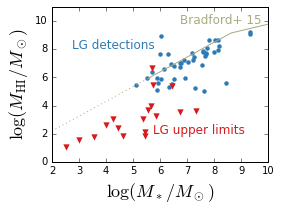

In [56]:
# the version to save
plt.figure(figsize=(4,3))
make_mhi_plot(scaling=1, annotation=True, legend=False)

plt.savefig('mstarmhi.pdf')
plt.savefig('mstarmhi.png')

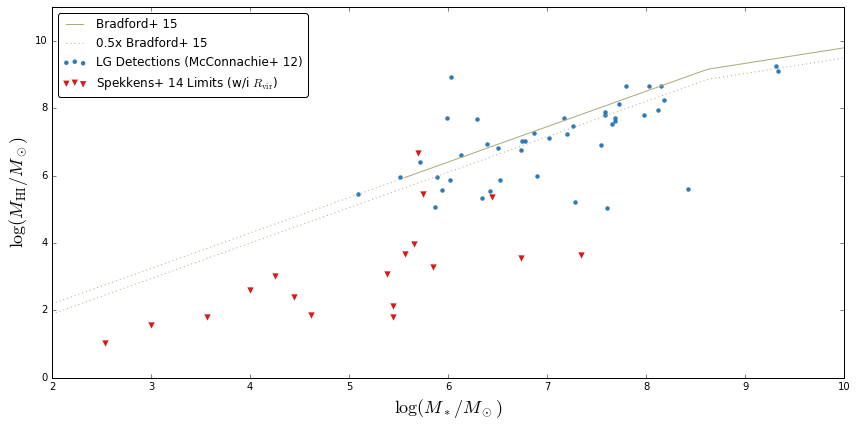

In [55]:
plt.figure(figsize=(12,6))
make_mhi_plot(scaled_brad=0.5, legend=True, annotation=False)